In [1]:
!nvidia-smi

Fri Nov  4 16:49:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:1B:00.0 Off |                  N/A |
| 41%   33C    P8    25W / 350W |      5MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    On   | 00000000:1C:00.0 Off |                  N/A |
| 40%   

## 1.套件載入及設置環境變數

os --> 為了設置GPU數量、找檔  
gc --> python的垃圾收集器  
cv2 --> openCV套件，主要用於讀取圖片  
time --> 計時套件  
pickle --> 將訓練每個epoch的acc及loss存為檔案  
model1582 --> 1582共同使用的模型架構  
numpy --> N維陣列，將圖片轉為np.array資料型態，為tensorflow指定image input & output的資料型態  
pandas --> dataframe資料型態，用於紀錄圖片路徑、label  
matplotlib --> 畫圖函式庫  
tensorflow --> 深度學習框架  
keras --> keras為tensorflow的高階函式庫，於tf2.0後加入tensorflow，不需額外安裝套件，載入方式由`import keras` --> `from tensorflow import keras`
* ModelCheckpoint --> 儲存模型的callback  
* TensorBoard --> 輸出模型及時訓練的儀錶板  
* optimizers --> 設定模型優化器

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
import gc
import cv2
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from livelossplot import PlotLossesKeras
import threading
from PIL import Image
import datetime as dt
import shutil
import statistics

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
import utility.model1582
from utility.DataLoading import dataLoading
from utility.DataProcessing import dataProcessing
from utility.FileProcessing import fileProcessing
from utility.FindCuttingLine import findCuttingLine
from utility.Plotimage import plotimage, plot_hist
from utility.EstimatePerformance import estimatePerformance
from utility.ImageProcessing import imageProcessing
from utility.PredictDataHandler import predictDataHandler
from utility.PredictionRunners import predictionRunners
from utility.PredictBatch import predictBatch

In [3]:
# 確認GPU功能正常
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
# 可用GPU列表，設定每張GPU記憶體隨訓練所需增長
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        print('set', device, 'error')
        pass
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

## 2.檔案路徑讀取

遍歷路徑下所有子資料夾，找出檔名結尾為jpg的檔案，紀錄路徑及label及defect code  
統計訓練集及驗證集的圖片數量及分布

In [4]:
config={
    'productline' : 'COG_ai_rebin',
    'model' : 'DM_MF',
    'project_tag' : 'FM_model',
    'training_paths':[
        '/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM_model',
    ],
    'test_paths':[
        '/tf/cp1ai01/COG/03_POC訓練資料/object_detection/test',
    ],
}

In [6]:
def create_folder(dic):
    now_time = time.time()
    time_structure = time.localtime(now_time)
    date = str(time_structure.tm_year)+"-"+str(time_structure.tm_mon)+"-"+str(time_structure.tm_mday)
    dirpath = f'{dic["productline"]}/{dic["model"]}/{date}_{dic["project_tag"]}/'
    if not os.path.isdir(dirpath):
        os.makedirs(dirpath)
    print("folder is created=\t\t",dirpath)
    return dirpath

In [7]:
dirpath=create_folder(config)

folder is created=		 COG_ai_rebin/DM_MF/2022-11-4_FM_model/


In [8]:
data_processor=dataProcessing(paths=config['training_paths'], split_symbol='-')

path=	 /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM_model
已完成(累積)=	 1325
                                            fullPath  \
0  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
1  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
2  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
3  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
4  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
5  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
6  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
7  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
8  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   
9  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...   

                                    fileName path-0 path-1   path-2 path-3  \
0  A-DMASA1-P53DMIU-031-(+0112+0003)-004.JPG            tf  cp1ai01    COG   
1    A-DMEG-P53DMDN-007-(+0279+0003)-016.JPG            tf  cp1ai01    COG   
2    A-DMEG-P53DMDN-034-(+0204+0005)-003.JPG            tf  cp1ai01    COG

classes_dic=	 {'FM_OK': 0, 'FM_NG': 1}
classes_dic_reverse=	 {0: 'FM_OK', 1: 'FM_NG'}
total=
 FM_NG    663
FM_OK    662
Name: class, dtype: int64


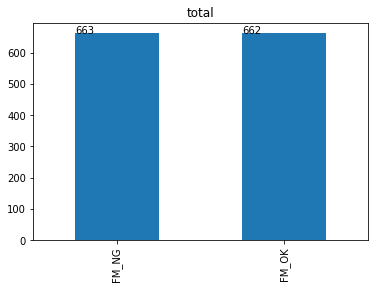

,fullPath,fileName,class,recipe,lotid
0,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,A-DMASA1-P53DMIU-031-(+0112+0003)-004.JPG,FM_OK,DMASA1,P53DMIU
1,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,A-DMEG-P53DMDN-007-(+0279+0003)-016.JPG,FM_OK,DMEG,P53DMDN
2,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,A-DMEG-P53DMDN-034-(+0204+0005)-003.JPG,FM_OK,DMEG,P53DMDN
3,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,A-DMG9-P53DMEC-029-(+0127+0002)-004.JPG,FM_OK,DMG9,P53DMEC
4,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,A-DMH5-P53DMGE-032-(+0058+0000)-003.JPG,FM_OK,DMH5,P53DMGE
...,...,...,...,...,...
1320,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,MFU4QD2-R30MFJQ-011-(+0169+0007)-011.JPG,FM_NG,MFU4QD2,R30MFJQ
1321,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,MFU4QD2-R31MFCC-007-(+0249+0003)-018.JPG,FM_NG,MFU4QD2,R31MFCC
1322,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,MFVG5-RK5MFB3-037-(+0227+0002)-015.JPG,FM_NG,MFVG5,RK5MFB3
1323,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/FM...,MFZRCC1-R30MFJU-036-(+0248+0004)-071.JPG,FM_NG,MFZRCC1,R30MFJU


In [9]:
cols={
    'fullPath':'fullPath',
    'fileName':'fileName',
    'path-7':'class',
    'fileName-0':'recipe',
    'fileName-1':'lotid'
}
dfPath_data=data_processor.setup_columns(col_dict=cols, class_col='class' ,class_col_replace={})
classes_dic=data_processor.classes_dic
classes_dic_reverse=data_processor.classes_dic_reverse
dfPath_data

shape(dftrain)=	 (4240, 7)
shape(dfvalid)=	 (1060, 7)
train=
 FM_OK    2144
FM_NG    2096
Name: class, dtype: int64


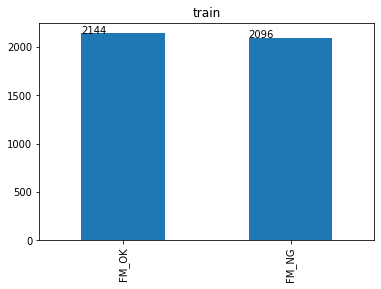

valid=
 FM_NG    556
FM_OK    504
Name: class, dtype: int64


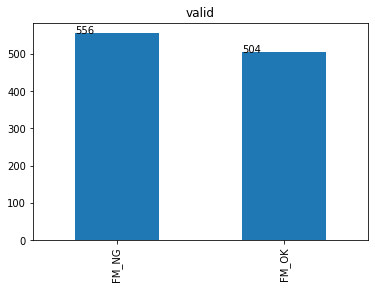

trainset.xlsx 儲存中...
COG_ai_rebin/DM_MF/2022-11-4_FM_model/trainset.xlsx 已儲存。


/usr/local/lib/python3.6/dist-packages/xlsxwriter/workbook.py:329: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [10]:
dfPath_data['rotation']=""
random_seed=8
dfPath_temp = pd.concat([
    dfPath_data,
    dfPath_data[dfPath_data['class'] == 'FM_OK'].assign(rotation='hor'),
    dfPath_data[dfPath_data['class'] == 'FM_OK'].assign(rotation='ver'),
    dfPath_data[dfPath_data['class'] == 'FM_OK'].assign(rotation='hor_ver'),
    dfPath_data[dfPath_data['class'] == 'FM_NG'].assign(rotation='hor'),
    dfPath_data[dfPath_data['class'] == 'FM_NG'].assign(rotation='ver'),
    dfPath_data[dfPath_data['class'] == 'FM_NG'].assign(rotation='hor_ver'),

]).reset_index()

dfPath_train,dfPath_valid=data_processor.split_train_valid(df=dfPath_temp, f=0.8, seed=random_seed, dirpath=dirpath)

## 3. 檔案讀取為`np.array`

在此步驟要決定輸入圖片的尺寸及通道數，透過openCV套件讀取圖片為`np.array`格式  
讀取的檔案要正規劃成0~1之間的數值(將所有值/255)  
y為二分法的結果(0或1)，若要使用softmax為最後一個輸出層，則要將y改為one-hot-encoding格式 ==> y=to_categorical(y)

In [11]:
validX, validY , _  = dataLoading(channel=1,
                    paths=dfPath_valid['fullPath'].values,
                    classes=dfPath_valid['class'].values,
                    rotation=dfPath_valid['rotation'].values).gen_XY()

100.0% [####################] 1060/1060 10.4s FPS=101.7
progressBar ends at 2022-11-04 05:21:36 .
+-------+----------+---------+-------+
| Total | Progress | Time(s) |  FPS  |
+-------+----------+---------+-------+
|  1060 |   100%   |   10.4  | 101.7 |
+-------+----------+---------+-------+
X_shape=	 (1060, 224, 224)
Y_shape=	 (1060,)
skip_profile=	 0
skip_err=	 0


In [12]:
trainX, trainY , _  = dataLoading(channel=1,
                    paths=dfPath_train['fullPath'].values,
                    classes=dfPath_train['class'].values,
                    rotation=dfPath_train['rotation'].values).gen_XY()

100.0% [####################] 4240/4240 41.8s FPS=101.5
progressBar ends at 2022-11-04 05:22:25 .
+-------+----------+---------+-------+
| Total | Progress | Time(s) |  FPS  |
+-------+----------+---------+-------+
|  4240 |   100%   |   41.8  | 101.5 |
+-------+----------+---------+-------+
X_shape=	 (4240, 224, 224)
Y_shape=	 (4240,)
skip_profile=	 0
skip_err=	 0


class=	 FM_OK


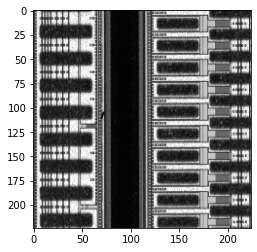

class=	 FM_NG


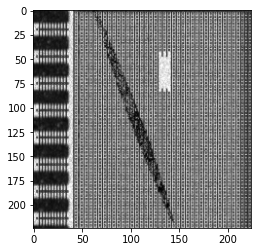

class=	 FM_OK


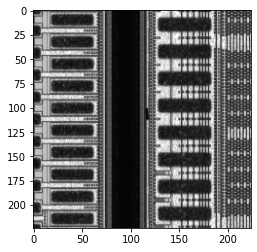

class=	 FM_NG


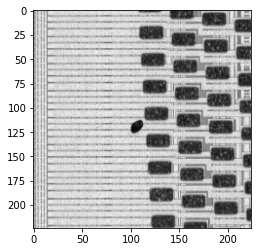

class=	 FM_NG


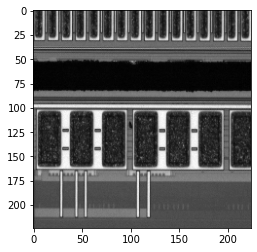

class=	 FM_OK


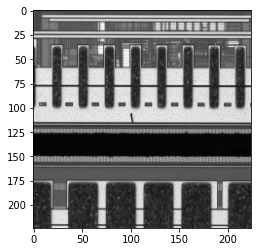

class=	 FM_OK


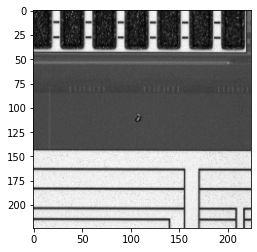

class=	 FM_NG


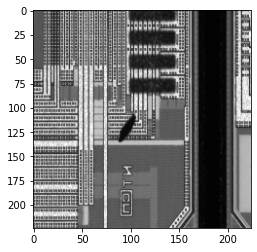

In [13]:
for i in range(4,12,1):
    print(f'class=\t',trainY[i])
    plt.imshow(trainX[i]*255,cmap='gray')
    plt.show()

## 4.模型讀取

1. 多GPU訓練需設置`MirroredStrategy`，將batch的圖片再平分給所有GPU運算  
2. 讀取的模型可以使用`model1582.py`中所定義的模型架構  
3. 讀取模型後要進行模型編譯，在此步驟加入loss function及optimizer，metrics代表模型歷史紀錄所儲存的資訊，可以再加入Precision、Recall等等  
4. `model.summary()`可以秀出模型架構及參數量，`plot_model`可以將模型輸出成圖像，可以更直覺檢視模型
5. callbacks可以加入多個功能，包括存模型的checkpoint、early stop、tensorboard等等
6. tf.keras.applications :
| Model             | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
|-------------------|-----------|----------------|----------------|------------|-------|------------------------------------|------------------------------------|
| Xception          | 88        | 79.00%         | 94.50%         | 22.9M      | 81    | 109.4                              | 8.1                                |
| VGG16             | 528       | 71.30%         | 90.10%         | 138.4M     | 16    | 69.5                               | 4.2                                |
| VGG19             | 549       | 71.30%         | 90.00%         | 143.7M     | 19    | 84.8                               | 4.4                                |
| ResNet50          | 98        | 74.90%         | 92.10%         | 25.6M      | 107   | 58.2                               | 4.6                                |
| ResNet50V2        | 98        | 76.00%         | 93.00%         | 25.6M      | 103   | 45.6                               | 4.4                                |
| ResNet101         | 171       | 76.40%         | 92.80%         | 44.7M      | 209   | 89.6                               | 5.2                                |
| ResNet101V2       | 171       | 77.20%         | 93.80%         | 44.7M      | 205   | 72.7                               | 5.4                                |
| ResNet152         | 232       | 76.60%         | 93.10%         | 60.4M      | 311   | 127.4                              | 6.5                                |
| ResNet152V2       | 232       | 78.00%         | 94.20%         | 60.4M      | 307   | 107.5                              | 6.6                                |
| InceptionV3       | 92        | 77.90%         | 93.70%         | 23.9M      | 189   | 42.2                               | 6.9                                |
| InceptionResNetV2 | 215       | 80.30%         | 95.30%         | 55.9M      | 449   | 130.2                              | 10                                 |
| MobileNet         | 16        | 70.40%         | 89.50%         | 4.3M       | 55    | 22.6                               | 3.4                                |
| MobileNetV2       | 14        | 71.30%         | 90.10%         | 3.5M       | 105   | 25.9                               | 3.8                                |
| DenseNet121       | 33        | 75.00%         | 92.30%         | 8.1M       | 242   | 77.1                               | 5.4                                |
| DenseNet169       | 57        | 76.20%         | 93.20%         | 14.3M      | 338   | 96.4                               | 6.3                                |
| DenseNet201       | 80        | 77.30%         | 93.60%         | 20.2M      | 402   | 127.2                              | 6.7                                |
| NASNetMobile      | 23        | 74.40%         | 91.90%         | 5.3M       | 389   | 27                                 | 6.7                                |
| NASNetLarge       | 343       | 82.50%         | 96.00%         | 88.9M      | 533   | 344.5                              | 20                                 |
| EfficientNetB0    | 29        | 77.10%         | 93.30%         | 5.3M       | 132   | 46                                 | 4.9                                |
| EfficientNetB1    | 31        | 79.10%         | 94.40%         | 7.9M       | 186   | 60.2                               | 5.6                                |
| EfficientNetB2    | 36        | 80.10%         | 94.90%         | 9.2M       | 186   | 80.8                               | 6.5                                |
| EfficientNetB3    | 48        | 81.60%         | 95.70%         | 12.3M      | 210   | 140                                | 8.8                                |
| EfficientNetB4    | 75        | 82.90%         | 96.40%         | 19.5M      | 258   | 308.3                              | 15.1                               |
| EfficientNetB5    | 118       | 83.60%         | 96.70%         | 30.6M      | 312   | 579.2                              | 25.3                               |
| EfficientNetB6    | 166       | 84.00%         | 96.80%         | 43.3M      | 360   | 958.1                              | 40.4                               |
| EfficientNetB7    | 256       | 84.30%         | 97.00%         | 66.7M      | 438   | 1578.9                             | 61.6                               |
| EfficientNetV2B0  | 29        | 78.70%         | 94.30%         | 7.2M       | -     | -                                  | -                                  |
| EfficientNetV2B1  | 34        | 79.80%         | 95.00%         | 8.2M       | -     | -                                  | -                                  |
| EfficientNetV2B2  | 42        | 80.50%         | 95.10%         | 10.2M      | -     | -                                  | -                                  |
| EfficientNetV2B3  | 59        | 82.00%         | 95.80%         | 14.5M      | -     | -                                  | -                                  |
| EfficientNetV2S   | 88        | 83.90%         | 96.70%         | 21.6M      | -     | -                                  | -                                  |
| EfficientNetV2M   | 220       | 85.30%         | 97.40%         | 54.4M      | -     | -                                  | -                                  |
| EfficientNetV2L   | 479       | 85.70%         | 97.50%         | 119.0M     | -     | -                                  | -                                  |
| ConvNeXtTiny      | 109.42    | 81.30%         | -              | 28.6M      | -     | -                                  | -                                  |
| ConvNeXtSmall     | 192.29    | 82.30%         | -              | 50.2M      | -     | -                                  | -                                  |
| ConvNeXtBase      | 338.58    | 85.30%         | -              | 88.5M      | -     | -                                  | -                                  |
| ConvNeXtLarge     | 755.07    | 86.30%         | -              | 197.7M     | -     | -                                  | -                                  |
| ConvNeXtXLarge    | 1310      | 86.70%         | -              | 350.1M     | -     | -                                  | -                                  |
> https://keras.io/api/applications/

In [ ]:
if len(classes_dic)==2:
    loss_func='binary_crossentropy'
    pred_output=1
    pred_activation='sigmoid'
else:
    loss_func='categorical_crossentropy'
    pred_output=len(classes_dic)
    pred_activation='softmax'

print('loss_func=\t\t',loss_func)
print('pred_output=\t\t',pred_output)
print('pred_activation=\t',pred_activation)

In [5]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
with strategy.scope():
      model=load_model('/tf/hsien/ai_rebin/COG_ai_rebin/DM_MF/2022-11-3_FM_model/FM_model_best_acc.h5')
#     base_model= tf.keras.applications.InceptionResNetV2(include_top=False,weights=None,input_shape=(224,224,1))
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu')(x)
#     predictions = Dense(pred_output, activation=pred_activation)(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

## 5.模型訓練

* 輸入的X,Y皆為np.array格式
* epoch:訓練次數
* batch_size:一次讀取多少圖片進模型訓練
* validation_data:驗證集X,Y，也可以設定由訓練集抽多少比例當作驗證集

模型訓練完畢會回傳訓練歷程，可以將此訓練歷程繪製成表，檢視每個epoch結束後的loss及acc等等metrics，最後將此歷程存為pickle，未來能再讀取

In [20]:
class gcCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

def data_generator(data, targets, batch_size):
    batches = (len(data) + batch_size - 1)//batch_size
    while(True):
        for i in range(batches):
            X = data[i*batch_size : (i+1)*batch_size]
            Y = targets[i*batch_size : (i+1)*batch_size]
            yield (X, Y)

filepath=dirpath+f"{config['project_tag']}_best_acc.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=50, mode='max')
callbacks_list = [checkpoint, gcCallback(), earlyStopping, PlotLossesKeras()]

In [21]:
model.compile(loss=loss_func,
              optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              metrics=['accuracy']
)

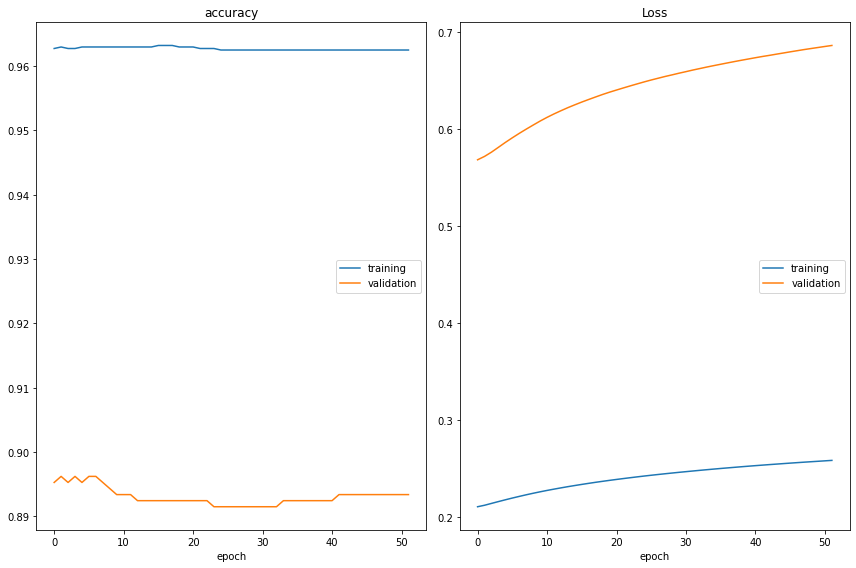

accuracy
	training         	 (min:    0.962, max:    0.963, cur:    0.962)
	validation       	 (min:    0.892, max:    0.896, cur:    0.893)
Loss
	training         	 (min:    0.210, max:    0.258, cur:    0.258)
	validation       	 (min:    0.568, max:    0.686, cur:    0.686)
Epoch 00052: early stopping
訓練共耗時: 18.54 分鐘


In [68]:
starttime = time.time()
batch_size = 400
hist=model.fit_generator(
    generator = data_generator(trainX, trainY, batch_size),
    steps_per_epoch = (len(trainX) + batch_size - 1) // batch_size,
    epochs=350,
    validation_data=(validX, validY),
    callbacks=callbacks_list,
)
endtime = time.time()
print('訓練共耗時:',round((endtime - starttime)/60, 2), '分鐘')

In [81]:
with open(dirpath+f'model_hist.pickle', 'wb') as f:
    pickle.dump(hist.history, f)

## 6.模型測試

In [6]:
test_processor=dataProcessing(paths=config["test_paths"], split_symbol='-')

path=	 /tf/cp1ai01/COG/03_POC訓練資料/object_detection/test
已完成(累積)=	 1000
                                            fullPath  \
0  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
1  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
2  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
3  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
4  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
5  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
6  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
7  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
8  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   
9  /tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...   

                                        fileName path-0 path-1   path-2  \
0        DMBMC3-R27DMT8-010-(+0106+0002)-184.JPG            tf  cp1ai01   
1        DMW1C4-R37DMCQ-037-(+0139+0004)-033.JPG            tf  cp1ai01   
2  MF47HGEBNUCD-RJ7MFC1-012-(+0012+0387)-039.JPG            tf  cp1ai01   
3        DMA

classes_dic=	 {'FM_OK': 0, 'FM_NG': 1}
classes_dic_reverse=	 {0: 'FM_OK', 1: 'FM_NG'}
total=
 FM_OK    500
FM_NG    500
Name: class, dtype: int64


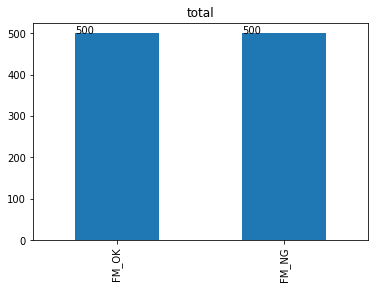

,fullPath,fileName,class,recipe,lotid
0,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMBMC3-R27DMT8-010-(+0106+0002)-184.JPG,FM_NG,DMBMC3,R27DMT8
1,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMW1C4-R37DMCQ-037-(+0139+0004)-033.JPG,FM_NG,DMW1C4,R37DMCQ
2,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,MF47HGEBNUCD-RJ7MFC1-012-(+0012+0387)-039.JPG,FM_NG,MF47HGEBNUCD,RJ7MFC1
3,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMASA1-R39DMEC-033-(+0128+0000)-003.JPG,FM_NG,DMASA1,R39DMEC
4,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,MFU4QD2-R31MFC9-007-(+0032+0002)-001.JPG,FM_NG,MFU4QD2,R31MFC9
...,...,...,...,...,...
995,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMGA-P53DMBW-032-(+0073+0005)-004.JPG,FM_OK,DMGA,P53DMBW
996,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMH5-P53DMGE-031-(+0147+0002)-006.JPG,FM_OK,DMH5,P53DMGE
997,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMH5-P53DMIP-011-(+0142+0002)-003.JPG,FM_OK,DMH5,P53DMIP
998,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMOXB3-P53DMGT-010-(+0081+0005)-007.JPG,FM_OK,DMOXB3,P53DMGT


In [7]:
cols={
    'fullPath':'fullPath',
    'fileName':'fileName',
    'path-7':'class',
    'fileName-0':'recipe',
    'fileName-1':'lotid'
}
dftest_data=test_processor.setup_columns(col_dict=cols, class_col='class' ,class_col_replace={})
dftest_data

In [8]:
pred=predictBatch(
    model=model,
    paths=dftest_data['fullPath'].values,
    channel=1,
    n=10000,
    batch_size=128).prediction

100.0% [####################] 1000/1000 31.0s FPS=32.3
the progress ends at 2022-11-04 07:34:45 .
+-------+----------+---------+------+
| Total | Progress | Time(s) | FPS  |
+-------+----------+---------+------+
|  1000 |   100%   |   31.0  | 32.3 |
+-------+----------+---------+------+


In [9]:
pred_handler=predictDataHandler(pred)

output dimension= 1


In [10]:
df=pred_handler.binay_classes(threshold=0.5,export_df=True)
df

convert to dataframe with shape=(1000, 2)


,top1_class,top1_score
0,NG,0.74659
1,OK,0.06395
2,NG,0.99660
3,NG,1.00000
4,NG,0.99996
...,...,...
995,OK,0.00001
996,OK,0.14524
997,NG,0.72829
998,OK,0.00106


In [11]:
dftest_data = pd.concat([dftest_data,df],axis=1)
dftest_data

,fullPath,fileName,class,recipe,lotid,top1_class,top1_score
0,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMBMC3-R27DMT8-010-(+0106+0002)-184.JPG,FM_NG,DMBMC3,R27DMT8,NG,0.74659
1,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMW1C4-R37DMCQ-037-(+0139+0004)-033.JPG,FM_NG,DMW1C4,R37DMCQ,OK,0.06395
2,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,MF47HGEBNUCD-RJ7MFC1-012-(+0012+0387)-039.JPG,FM_NG,MF47HGEBNUCD,RJ7MFC1,NG,0.99660
3,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMASA1-R39DMEC-033-(+0128+0000)-003.JPG,FM_NG,DMASA1,R39DMEC,NG,1.00000
4,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,MFU4QD2-R31MFC9-007-(+0032+0002)-001.JPG,FM_NG,MFU4QD2,R31MFC9,NG,0.99996
...,...,...,...,...,...,...,...
995,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMGA-P53DMBW-032-(+0073+0005)-004.JPG,FM_OK,DMGA,P53DMBW,OK,0.00001
996,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMH5-P53DMGE-031-(+0147+0002)-006.JPG,FM_OK,DMH5,P53DMGE,OK,0.14524
997,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMH5-P53DMIP-011-(+0142+0002)-003.JPG,FM_OK,DMH5,P53DMIP,NG,0.72829
998,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMOXB3-P53DMGT-010-(+0081+0005)-007.JPG,FM_OK,DMOXB3,P53DMGT,OK,0.00106


In [12]:
dftest_data['gt']=np.where(dftest_data['class']=="FM_NG",'NG',"OK")
dftest_data

,fullPath,fileName,class,recipe,lotid,top1_class,top1_score,gt
0,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMBMC3-R27DMT8-010-(+0106+0002)-184.JPG,FM_NG,DMBMC3,R27DMT8,NG,0.74659,NG
1,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMW1C4-R37DMCQ-037-(+0139+0004)-033.JPG,FM_NG,DMW1C4,R37DMCQ,OK,0.06395,NG
2,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,MF47HGEBNUCD-RJ7MFC1-012-(+0012+0387)-039.JPG,FM_NG,MF47HGEBNUCD,RJ7MFC1,NG,0.99660,NG
3,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,DMASA1-R39DMEC-033-(+0128+0000)-003.JPG,FM_NG,DMASA1,R39DMEC,NG,1.00000,NG
4,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,MFU4QD2-R31MFC9-007-(+0032+0002)-001.JPG,FM_NG,MFU4QD2,R31MFC9,NG,0.99996,NG
...,...,...,...,...,...,...,...,...
995,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMGA-P53DMBW-032-(+0073+0005)-004.JPG,FM_OK,DMGA,P53DMBW,OK,0.00001,OK
996,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMH5-P53DMGE-031-(+0147+0002)-006.JPG,FM_OK,DMH5,P53DMGE,OK,0.14524,OK
997,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMH5-P53DMIP-011-(+0142+0002)-003.JPG,FM_OK,DMH5,P53DMIP,NG,0.72829,OK
998,/tf/cp1ai01/COG/03_POC訓練資料/object_detection/te...,A-DMOXB3-P53DMGT-010-(+0081+0005)-007.JPG,FM_OK,DMOXB3,P53DMGT,OK,0.00106,OK


threshold_list=	 [0.01, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
--------------------------------
thres=	 0.01
gt      OK   NG   All
row_0                
OK     316   89   405
NG     184  411   595
All    500  500  1000
--------------------------------
thres=	 0.01
gt      OK   NG   All
row_0                
OK     316   89   405
NG     184  411   595
All    500  500  1000
--------------------------------
thres=	 0.05
gt      OK   NG   All
row_0                
OK     351  113   464
NG     149  387   536
All    500  500  1000
--------------------------------
thres=	 0.1
gt      OK   NG   All
row_0                
OK     363  129   492
NG     137  371   508
All    500  500  1000
--------------------------------
thres=	 0.2
gt      OK   NG   All
row_0                
OK     379  139   518
NG     121  361   482
All    500  500  1000
--------------------------------
thres=	 0.3
gt      OK   NG   All
row_0                
OK     390  146   536
NG     110  354   464
Al

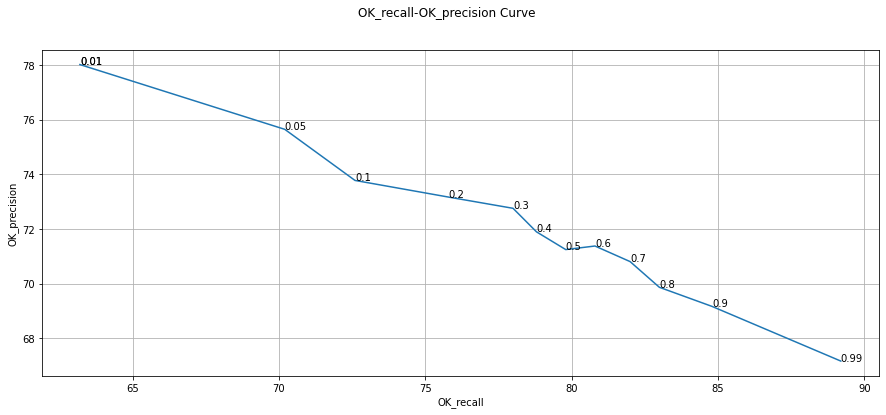

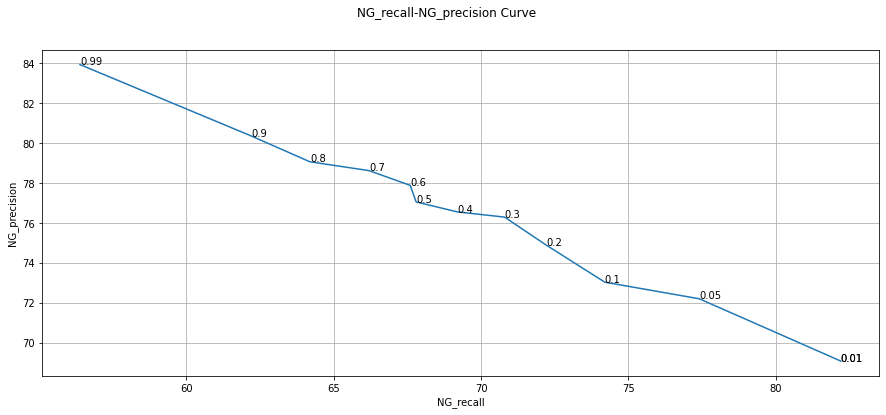

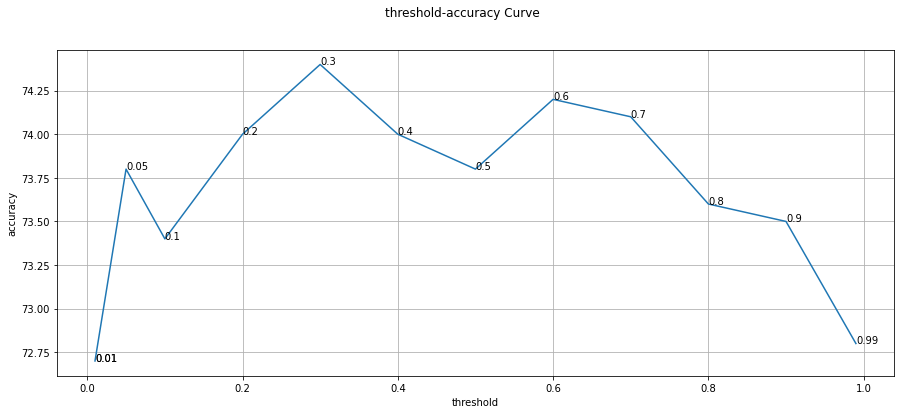

,0.01,0.01,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.99
total,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
OK,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
NG,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
NG_recall,82.20,82.20,77.40,74.20,72.20,70.80,69.20,67.80,67.60,66.20,64.20,62.20,56.40
NG_precision,69.08,69.08,72.20,73.03,74.90,76.29,76.55,77.05,77.88,78.62,79.06,80.36,83.93
OK_recall,63.20,63.20,70.20,72.60,75.80,78.00,78.80,79.80,80.80,82.00,83.00,84.80,89.20
OK_precision,78.02,78.02,75.65,73.78,73.17,72.76,71.90,71.25,71.38,70.81,69.87,69.17,67.17
underkill,89.00,89.00,113.00,129.00,139.00,146.00,154.00,161.00,162.00,169.00,179.00,189.00,218.00
underkill%,8.90,8.90,11.30,12.90,13.90,14.60,15.40,16.10,16.20,16.90,17.90,18.90,21.80
overkill,184.00,184.00,149.00,137.00,121.00,110.00,106.00,101.00,96.00,90.00,85.00,76.00,54.00


In [13]:
threhold=[0.01,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
performance=estimatePerformance().thresholding(
    gt=dftest_data['gt'],
    score=dftest_data['top1_score'],
    threshold_list=threhold,
    plot=True
)
performance

In [115]:
dftest_data.to_excel(dirpath+'result.xlsx')
performance.to_excel(dirpath+'summary.xlsx')